In [1]:
import pandas as pd
import numpy as np
import math
import shap
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight,compute_sample_weight
from astropy.coordinates import SkyCoord
import astropy.units as u
from xgboost import XGBClassifier
from grb_ml_utils import *

In [2]:
grbgen, big_table = load_big_greiner()

Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
print(len(big_table))
print(np.sum(big_table['class']==0))
print(np.sum(big_table['class']==1))
print(np.sum(np.logical_and(big_table['class']==0,big_table['T90']<np.log10(2))))
print(np.sum(np.logical_and(big_table['class']==1,big_table['T90']>np.log10(2))))
print(np.sum(np.logical_and(np.logical_and(big_table['T90']>np.log10(0.5),big_table['T90']<np.log10(4)),big_table['class']!=-1)))
print(np.sum(np.logical_and(np.logical_and(big_table['T90']>np.log10(0.5),big_table['T90']<np.log10(4)),big_table['class']==0)))
print(np.sum(np.logical_and(np.logical_and(big_table['T90']>np.log10(0.5),big_table['T90']<np.log10(4)),big_table['class']==1)))

5453
1351
109
46
15
138
93
45


In [6]:
prompt_emission = ['T90', 'z','D_L',
                   'F_g', 'HR', 'E_iso', 'L_pk', 'F_pk1',
                   'P_pk4', 'alpha_band', 'beta_band', 'E_P_band',
                   'alpha_cpl', 'E_P_cpl', 'alpha_spl','spectral_lag']
prompt_emission_no_t90 = ['z','D_L',
                   'F_g', 'HR', 'E_iso', 'L_pk', 'F_pk1',
                   'P_pk4', 'alpha_band', 'beta_band', 'E_P_band',
                   'alpha_cpl', 'E_P_cpl', 'alpha_spl','spectral_lag']
prompt_emission_no_t90_fg_hr = ['z','D_L',
                   'E_iso', 'L_pk', 'F_pk1',
                   'P_pk4', 'alpha_band', 'beta_band', 'E_P_band',
                   'alpha_cpl', 'E_P_cpl', 'alpha_spl','spectral_lag']

afterglow = ['theta_j', 'Gamma0', 'log_t_burst',
             't_b',
             'F_X11hr', 'beta_X11hr', 'F_Opt11hr',
             'T_ai', 'L_a']

host_galaxy = ['offset', 'metallicity',
               'A_V', 'SFR',
               'SSFR', 'Age', 'Mass']
host_galaxy_no_offset = ['metallicity',
               'A_V', 'SFR',
               'SSFR', 'Age', 'Mass']

all_features = prompt_emission + afterglow + host_galaxy
t90_hr = ['T90','HR']

In [7]:
sim_number = 1000
def calc_f1(columns_to_use,tree_model=False):
    list_of_f1 = np.zeros(sim_number)
    list_of_inter_f1 = np.zeros(sim_number)
    list_of_mediate_f1 = np.zeros(sim_number)
    data_pd = big_table[big_table['class']!=-1]
    rows_to_use = np.zeros(len(data_pd),dtype=bool)
    for feature in columns_to_use:
        if feature=='T90':
            continue
        rows_to_use = np.logical_or(rows_to_use,data_pd[feature].notnull())
    data_pd = data_pd[rows_to_use].reset_index()

    intermingled_rows_to_use = np.logical_or(np.logical_and(data_pd['T90']>np.log10(2),data_pd['class']==1),np.logical_and(data_pd['T90']<np.log10(2),data_pd['class']==0))
    intermingled_list = intermingled_rows_to_use.index[intermingled_rows_to_use].to_numpy()
    intermediate_rows_to_use = np.logical_and(data_pd['T90']>np.log10(1),data_pd['T90']<np.log10(4))
    intermediate_list = intermediate_rows_to_use.index[intermediate_rows_to_use].to_numpy()
    data_feature = data_pd[columns_to_use]
    data_target = data_pd['class'].to_numpy()

    for i in range(sim_number):
        X,test_X,y,test_y = train_test_split(data_feature,data_target,test_size=0.3,stratify=data_target)
        
        if tree_model:
            clf = DecisionTreeClassifier(max_depth=3)
        else:
            clf = XGBClassifier(use_label_encoder=False,eval_metric='logloss')

        sample_weight = compute_sample_weight('balanced',y=y)
        clf.fit(X, y,sample_weight=sample_weight)
        predictions = clf.predict(test_X)
        list_of_f1[i] = f1_score(test_y,predictions)

        intermingled_feature = data_pd.loc[intermingled_rows_to_use,columns_to_use]
        intermingled_target = data_pd.loc[intermingled_rows_to_use,'class']
        intermingled_predictions = clf.predict(intermingled_feature)
        list_of_inter_f1[i] = f1_score(intermingled_target,intermingled_predictions)

        intermediate_feature = data_pd.loc[intermediate_rows_to_use,columns_to_use]
        intermediate_target = data_pd.loc[intermediate_rows_to_use,'class']
        intermediate_predictions = clf.predict(intermediate_feature)
        list_of_mediate_f1[i] = f1_score(intermediate_target,intermediate_predictions)
    return list_of_f1,list_of_inter_f1,list_of_mediate_f1

def plot_f1(list_of_f1,list_of_inter_f1,list_of_mediate_f1):
    plt.hist(list_of_f1,20,alpha=0.6,label='all')
    plt.hist(list_of_inter_f1,20,alpha=0.6,label='inter')
    plt.hist(list_of_mediate_f1,20,alpha=0.6,label='intermediate')
    plt.legend()
    print(np.round(np.average(list_of_f1),3),np.round(np.average(list_of_f1)-np.percentile(list_of_f1,16),3),np.round(np.percentile(list_of_f1,84)-np.average(list_of_f1),3))
    print(np.round(np.average(list_of_inter_f1),3),np.round(np.average(list_of_inter_f1)-np.percentile(list_of_inter_f1,16),3),np.round(np.percentile(list_of_inter_f1,84)-np.average(list_of_inter_f1),3))
    print(np.round(np.average(list_of_mediate_f1),3),np.round(np.average(list_of_mediate_f1)-np.percentile(list_of_mediate_f1,16),3),np.round(np.percentile(list_of_mediate_f1,84)-np.average(list_of_mediate_f1),3))
    print(r'$'+str(np.round(np.average(list_of_f1),3))+r'\substack{+'+
          str(np.round(np.percentile(list_of_f1,84)-np.average(list_of_f1),3))+r' \\ -'+
          str(np.round(np.average(list_of_f1)-np.percentile(list_of_f1,16),3))+r'}$ & $'+
          str(np.round(np.average(list_of_inter_f1),3))+r'\substack{+'+
          str(np.round(np.percentile(list_of_inter_f1,84)-np.average(list_of_inter_f1),3))+r' \\ -'+
          str(np.round(np.average(list_of_inter_f1)-np.percentile(list_of_inter_f1,16),3))+r'}$ & $'+
          str(np.round(np.average(list_of_mediate_f1),3))+r'\substack{+'+
          str(np.round(np.percentile(list_of_mediate_f1,84)-np.average(list_of_mediate_f1),3))+r' \\ -'+
          str(np.round(np.average(list_of_mediate_f1)-np.percentile(list_of_mediate_f1,16),3))+r'}$\\')
    return

0.75 0.05 0.05
0.635 0.095 0.092
0.843 0.053 0.057
$0.75\substack{+0.05 \\ -0.05}$ & $0.635\substack{+0.092 \\ -0.095}$ & $0.843\substack{+0.057 \\ -0.053}$\\


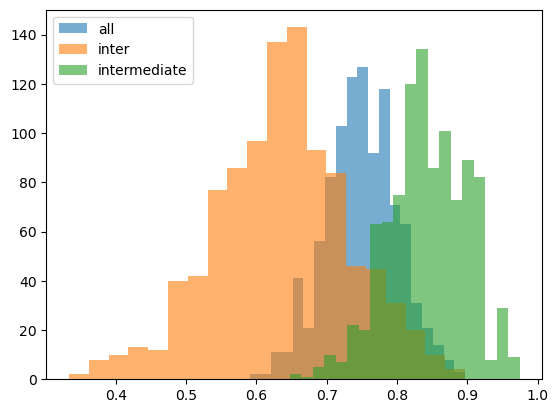

In [8]:
columns_to_use = prompt_emission
list_of_f1,list_of_inter_f1,list_of_mediate_f1 = calc_f1(columns_to_use)
plot_f1(list_of_f1,list_of_inter_f1,list_of_mediate_f1)

0.696 0.06 0.058
0.747 0.081 0.08
0.875 0.051 0.048
$0.696\substack{+0.058 \\ -0.06}$ & $0.747\substack{+0.08 \\ -0.081}$ & $0.875\substack{+0.048 \\ -0.051}$\\


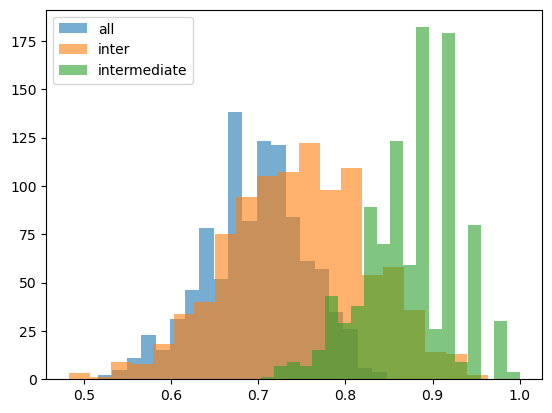

In [9]:
columns_to_use = prompt_emission_no_t90
list_of_f1,list_of_inter_f1,list_of_mediate_f1 = calc_f1(columns_to_use)
plot_f1(list_of_f1,list_of_inter_f1,list_of_mediate_f1)

0.523 0.071 0.067
0.777 0.085 0.08
0.86 0.06 0.054
$0.523\substack{+0.067 \\ -0.071}$ & $0.777\substack{+0.08 \\ -0.085}$ & $0.86\substack{+0.054 \\ -0.06}$\\


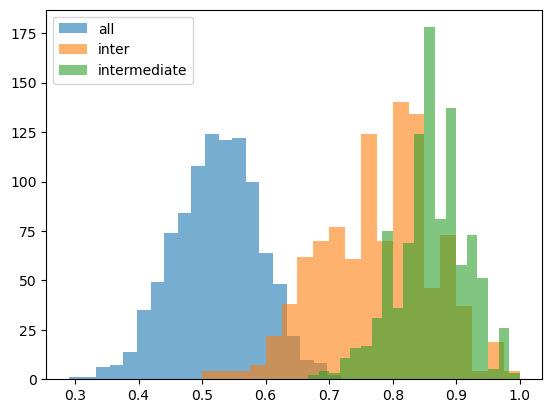

In [10]:
columns_to_use = prompt_emission_no_t90_fg_hr
list_of_f1,list_of_inter_f1,list_of_mediate_f1 = calc_f1(columns_to_use)
plot_f1(list_of_f1,list_of_inter_f1,list_of_mediate_f1)

0.439 0.094 0.094
0.798 0.084 0.077
0.835 0.085 0.099
$0.439\substack{+0.094 \\ -0.094}$ & $0.798\substack{+0.077 \\ -0.084}$ & $0.835\substack{+0.099 \\ -0.085}$\\


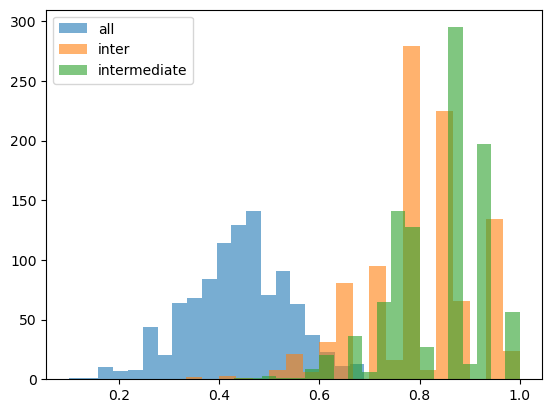

In [11]:
columns_to_use = afterglow
list_of_f1,list_of_inter_f1,list_of_mediate_f1 = calc_f1(columns_to_use)
plot_f1(list_of_f1,list_of_inter_f1,list_of_mediate_f1)

0.652 0.089 0.089
0.892 0.092 0.108
0.946 0.071 0.054
$0.652\substack{+0.089 \\ -0.089}$ & $0.892\substack{+0.108 \\ -0.092}$ & $0.946\substack{+0.054 \\ -0.071}$\\


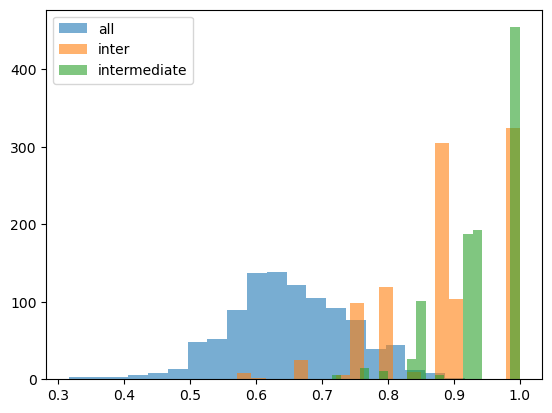

In [12]:
columns_to_use = host_galaxy
list_of_f1,list_of_inter_f1,list_of_mediate_f1 = calc_f1(columns_to_use)
plot_f1(list_of_f1,list_of_inter_f1,list_of_mediate_f1)

0.513 0.113 0.107
0.809 0.142 0.101
0.892 0.059 0.108
$0.513\substack{+0.107 \\ -0.113}$ & $0.809\substack{+0.101 \\ -0.142}$ & $0.892\substack{+0.108 \\ -0.059}$\\


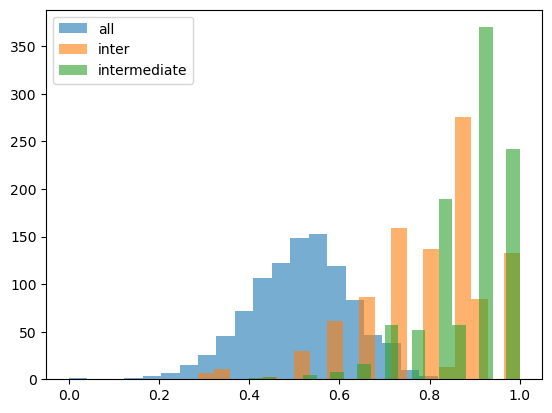

In [13]:
columns_to_use = host_galaxy_no_offset
list_of_f1,list_of_inter_f1,list_of_mediate_f1 = calc_f1(columns_to_use)
plot_f1(list_of_f1,list_of_inter_f1,list_of_mediate_f1)

0.759 0.05 0.052
0.633 0.096 0.1
0.851 0.051 0.049
$0.759\substack{+0.052 \\ -0.05}$ & $0.633\substack{+0.1 \\ -0.096}$ & $0.851\substack{+0.049 \\ -0.051}$\\


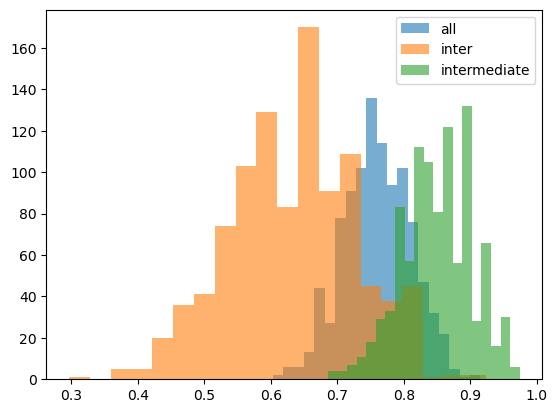

In [14]:
columns_to_use = all_features
list_of_f1,list_of_inter_f1,list_of_mediate_f1 = calc_f1(columns_to_use)
plot_f1(list_of_f1,list_of_inter_f1,list_of_mediate_f1)

0.75 0.048 0.05
0.148 0.028 0.052
0.617 0.079 0.05
$0.75\substack{+0.05 \\ -0.048}$ & $0.148\substack{+0.052 \\ -0.028}$ & $0.617\substack{+0.05 \\ -0.079}$\\


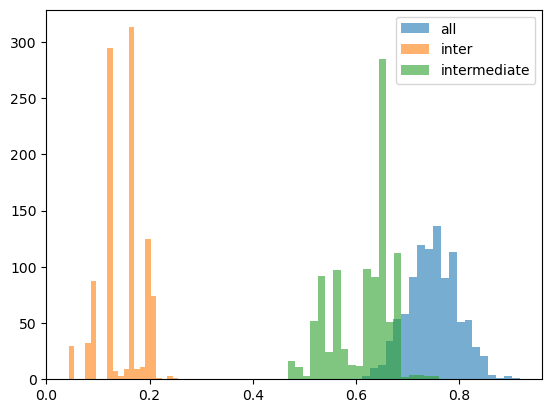

In [15]:
columns_to_use = t90_hr
list_of_f1,list_of_inter_f1,list_of_mediate_f1 = calc_f1(columns_to_use,tree_model=True)
plot_f1(list_of_f1,list_of_inter_f1,list_of_mediate_f1)